In [46]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta, datetime
import os
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

Pull into memory daily sales volumes

In [52]:
daily_product_df = pd.read_csv('./Historical Product Demand.csv')
daily_product_df['Date'] = pd.to_datetime(daily_product_df['Date'])
daily_product_df = daily_product_df[daily_product_df['Date'].notnull()]
daily_product_df['Order_Demand'] = daily_product_df['Order_Demand'].str.replace(r"\(.*\)",'1')
daily_product_df['Order_Demand'] = daily_product_df['Order_Demand'].astype(str).astype(int)
daily_product_df = daily_product_df[daily_product_df['Warehouse']!='Whse_A']
daily_product_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


Pull into memory holiday dates

In [53]:
holiday_df = pd.read_csv('./US Holiday Dates (2004-2021).csv')
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])
holiday_df['holiday_boolean'] = 1
holiday_df = holiday_df[['Date','holiday_boolean']]
holiday_df = holiday_df.drop_duplicates()
holiday_df.set_index('Date', inplace=True)
holiday_df.head()

,holiday_boolean
Date,
2004-07-04,1
2005-07-04,1
2006-07-04,1
2007-07-04,1
2008-07-04,1


Merge holidays into sales dataframe

In [54]:
print(daily_product_df.shape)
daily_product_df.set_index('Date', inplace=True)
daily_product_df = daily_product_df.merge(holiday_df, left_index=True, right_index=True, how='left')
print(daily_product_df.shape)

(895001, 5)
(895001, 5)


In [55]:
daily_product_df.reset_index(drop=False, inplace=True)

In [56]:
daily_product_df['holiday_boolean'] = daily_product_df['holiday_boolean'].fillna(0)
daily_product_df.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand,holiday_boolean
0,2011-06-24,Product_1521,Whse_S,Category_019,85000,0.0
1,2011-06-24,Product_1521,Whse_S,Category_019,7000,0.0
2,2011-09-02,Product_1507,Whse_C,Category_019,1250,0.0
3,2011-09-27,Product_0608,Whse_C,Category_001,5,0.0
4,2011-09-27,Product_1933,Whse_C,Category_001,23,0.0


In [57]:
daily_product_df.shape[0]

895001

Output data aggregated at daily-level per Warehouse: Showcase how to aggregate & Forecast within Tabpy

In [59]:
daily_product_df.set_index('Date', inplace=True)
grouper = daily_product_df.groupby([pd.Grouper(freq='D'), 'Warehouse'])
daily_df = grouper['Order_Demand'].sum()
daily_df = daily_df.reset_index(drop=False)
daily_df.head()

,Date,Warehouse,Order_Demand
0,2011-06-24,Whse_S,92000
1,2011-09-02,Whse_C,1250
2,2011-09-27,Whse_C,28
3,2011-09-30,Whse_C,5450
4,2011-10-20,Whse_S,2


In [60]:
daily_df = daily_df.set_index(
    ['Date', 'Warehouse']
).unstack(
    fill_value=0
).asfreq(
    'D', fill_value=0
).stack().sort_index(level=1).reset_index()

daily_df.head()

,Date,Warehouse,Order_Demand
0,2011-06-24,Whse_C,0
1,2011-06-25,Whse_C,0
2,2011-06-26,Whse_C,0
3,2011-06-27,Whse_C,0
4,2011-06-28,Whse_C,0


In [63]:
daily_df = daily_df[daily_df['Date']>='2012-01-01']
daily_df.head()

,Date,Warehouse,Order_Demand
191,2012-01-01,Whse_C,0
192,2012-01-02,Whse_C,0
193,2012-01-03,Whse_C,275137
194,2012-01-04,Whse_C,204000
195,2012-01-05,Whse_C,298318


In [67]:
holiday_df.reset_index(drop=False, inplace=True)

In [69]:
daily_df = daily_df.merge(holiday_df, on='Date', how='left')

In [72]:
daily_df['holiday_boolean'] = daily_df['holiday_boolean'].fillna(0)

In [79]:
daily_df['Date'].max()

Timestamp('2017-01-09 00:00:00')

In [75]:
daily_df.to_csv('./daily_warehouse_demand.csv', index=False)

Generates monthly aggregations with one record per Month and Warehouse

In [62]:
# daily_product_df.set_index('Date', inplace=True)
grouper = daily_product_df.groupby([pd.Grouper(freq='MS'), 'Warehouse'])
monthly_df = grouper['Order_Demand'].sum()
monthly_df = monthly_df.reset_index(drop=False)
monthly_df.head()

,Date,Warehouse,Order_Demand
0,2011-06-01,Whse_S,92000
1,2011-09-01,Whse_C,6728
2,2011-10-01,Whse_C,3
3,2011-10-01,Whse_S,2
4,2011-11-01,Whse_C,57252


In [37]:
monthly_df = monthly_df[monthly_df['Date'] >= '2012-01-01']

In [38]:
monthly_df = monthly_df.set_index(
    ['Date', 'Warehouse']
).unstack(
    fill_value=0
).asfreq(
    'MS', fill_value=0
).stack().sort_index(level=1).reset_index()

monthly_df.head()

,Date,Warehouse,Order_Demand
0,2012-01-01,Whse_C,4245166
1,2012-02-01,Whse_C,10966974
2,2012-03-01,Whse_C,11296947
3,2012-04-01,Whse_C,7022400
4,2012-05-01,Whse_C,8203107


In [80]:
monthly_df['Date'].max()

Timestamp('2017-01-01 00:00:00')

In [45]:
monthly_df.to_csv('./monthly_warehouse_demand.csv', index=False)

Produces monthly aggregation with one record per month, and one column per Warehouse

In [276]:
piv_df = daily_product_df.copy()

piv_df = piv_df[['Date','Warehouse', 'Order_Demand']].pivot_table(index='Date',
                                                           columns=['Warehouse'],
                                                          values=['Order_Demand'])

piv_df.columns = ['_'.join(col).strip().lower() for col in piv_df.columns.values]
piv_df.head()

,order_demand_whse_c,order_demand_whse_j,order_demand_whse_s
Date,,,
2011-06-24,NaN,NaN,46000.0
2011-09-02,1250.0,NaN,NaN
2011-09-27,14.0,NaN,NaN
2011-09-30,5450.0,NaN,NaN
2011-10-20,NaN,NaN,1.0


In [277]:
piv_df.reset_index(drop=False, inplace=True)
piv_df = piv_df.merge(daily_product_df[['Date','holiday_boolean']].drop_duplicates(), how='left', on='Date')
piv_df = piv_df.fillna(0)
piv_df = piv_df[piv_df['Date'] >= '2012-01-01']
piv_df.head()

,Date,order_demand_whse_c,order_demand_whse_j,order_demand_whse_s,holiday_boolean
34,2012-01-01,NaN,NaN,2.000000,1.0
35,2012-01-02,NaN,NaN,12359.581818,0.0
36,2012-01-03,5394.843137,NaN,28981.619048,0.0
37,2012-01-04,29142.857143,120.000000,11620.204545,0.0
38,2012-01-05,7457.950000,5392.133028,86726.266667,0.0


Output data at the daily level in case you would like to practice aggregating to monthly level within Tableau before feeding to forecasting model

In [279]:
piv_df.to_csv('./daily_warehouse_demand.csv', index=False)

In [263]:
piv_df.set_index('Date', inplace=True)
monthly_df = piv_df.resample('MS').sum()
monthly_df['holiday_boolean'] = np.where(monthly_df['holiday_boolean']>=1, 1, 0)
monthly_df.head()

,order_demand_whse_c,order_demand_whse_j,order_demand_whse_s,holiday_boolean
Date,,,,
2012-01-01,274633.090776,77179.141669,309016.545502,1
2012-02-01,395688.347184,87704.158212,283537.669923,1
2012-03-01,381246.864363,82741.934347,352378.472221,0
2012-04-01,234515.120840,107588.888029,459757.951342,1
2012-05-01,340654.115970,111797.757378,348878.701966,1


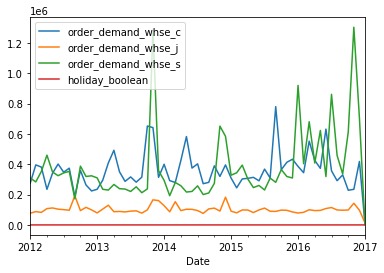

In [264]:
monthly_df.plot()

In [265]:
monthly_df.head()

,order_demand_whse_c,order_demand_whse_j,order_demand_whse_s,holiday_boolean
Date,,,,
2012-01-01,274633.090776,77179.141669,309016.545502,1
2012-02-01,395688.347184,87704.158212,283537.669923,1
2012-03-01,381246.864363,82741.934347,352378.472221,0
2012-04-01,234515.120840,107588.888029,459757.951342,1
2012-05-01,340654.115970,111797.757378,348878.701966,1


In [266]:
monthly_df = monthly_df[monthly_df.index >= '2012-01-01']

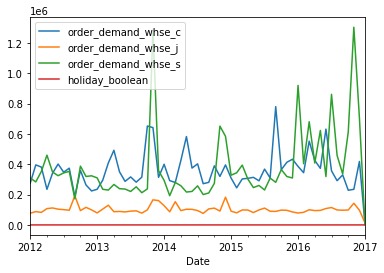

In [267]:
monthly_df.plot()

In [268]:
monthly_df.head()

,order_demand_whse_c,order_demand_whse_j,order_demand_whse_s,holiday_boolean
Date,,,,
2012-01-01,274633.090776,77179.141669,309016.545502,1
2012-02-01,395688.347184,87704.158212,283537.669923,1
2012-03-01,381246.864363,82741.934347,352378.472221,0
2012-04-01,234515.120840,107588.888029,459757.951342,1
2012-05-01,340654.115970,111797.757378,348878.701966,1


In [269]:
index = pd.date_range(start = monthly_df.index.min(), end = monthly_df.index.max(), freq='MS')
monthly_df = monthly_df.reindex(index)
monthly_df.index.names = ['month']
monthly_df.reset_index(drop=False, inplace=True)


In [270]:
monthly_df.head()

,month,order_demand_whse_c,order_demand_whse_j,order_demand_whse_s,holiday_boolean
0,2012-01-01,274633.090776,77179.141669,309016.545502,1
1,2012-02-01,395688.347184,87704.158212,283537.669923,1
2,2012-03-01,381246.864363,82741.934347,352378.472221,0
3,2012-04-01,234515.120840,107588.888029,459757.951342,1
4,2012-05-01,340654.115970,111797.757378,348878.701966,1


Use if you would like the data pre-aggregated at the monthly level

In [271]:
monthly_df.to_csv('./monthly_warehouse_demand.csv', index=False)